In [2]:
import pandas as pd
data = pd.read_csv("/content/MSFT.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,83.599998,84.809998,83.220001,84.260002,78.978004,29532100
1,2017-12-04,84.419998,84.430000,80.699997,81.080002,75.997337,39094900
2,2017-12-05,81.339996,82.680000,80.980003,81.589996,76.475357,26152300
3,2017-12-06,81.550003,83.139999,81.430000,82.779999,77.590767,26162100
4,2017-12-07,82.540001,82.800003,82.000000,82.489998,77.318954,23184500


In [3]:
data['Date'] =pd.to_datetime(data['Date'])
data.index= data['Date']

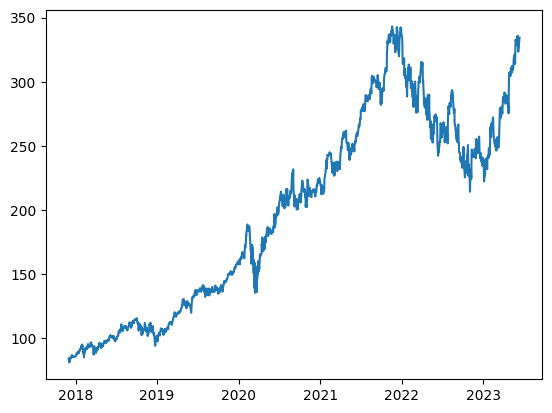

In [4]:
import matplotlib.pyplot as plt
plt.plot(data.index,data['Close'])

In [5]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


In [6]:
# 2. Đọc file dữ liệu chứng khoán DELL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv('/content/MSFT.csv')
df = df[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index



# Split the data into training, testing, and validation sets
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [7]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.4 MB/s eta 0:00:00


In [8]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
fit = model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3391.020, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3471.060, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3393.231, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3398.692, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3471.868, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3392.716, Time=0.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3369.682, Time=0.71 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3394.424, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3393.942, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3370.461, Time=1.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3389.332, Time=0.48 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3372.237, Time=2.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3373.849, Time=1.01 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 7.249 seconds


In [9]:
train_data.index

RangeIndex(start=0, stop=695, step=1)

In [10]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [11]:

from datetime import timedelta

In [12]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
#last_index =  df.index[-1]
last_index=len(df)
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[216.29210456 215.35651315 216.27577044 215.96689214 216.51489805
 216.44033155 216.83135894 216.86735605 217.17749611 217.27427219
 217.53792267 217.67066705 217.9062894  218.06097134 218.2793767
 218.44759309 218.65534827 218.83195027 219.0331005  219.21490606
 219.41195623 219.59699262 219.79149678 219.97853957 220.17146256
 220.35975143 220.5516924  220.74075519 220.93208624 221.1216297 ]


In [13]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)


Validation RMSE: 32.80169815183489
Testing RMSE: 26.648997025669452


RMSE thường được sử dụng để đánh giá độ chính xác của mô hình dự đoán với các giá trị liên tục, như giá cổ phiếu, điểm số, nhiệt độ, v.v. Giá trị RMSE càng nhỏ, mô hình dự đoán càng chính xác. Vậy với dữ liệu này mô hình Arima chính xác hơn

Validation RMSE: 32.80169815183489
Testing RMSE: 26.648997025669452
Validation MAE: 26.003000093086424
Testing MAE: 20.07932920998238
Validation MAPE: 0.09393014854910141
Testing MAPE: 0.0696076558991961


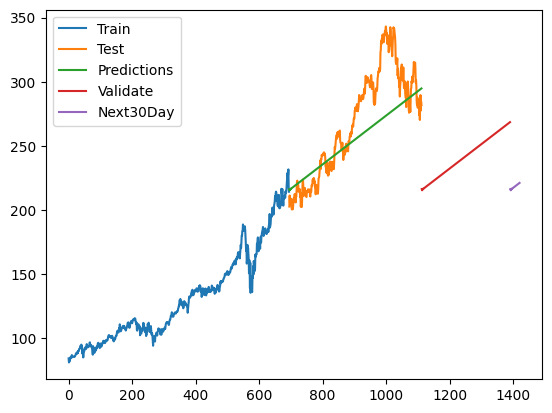

In [14]:


# 8. Tính RMSE, MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mae= np.mean(np.abs(y_pred_val - y_val))
test_mae= np.mean(np.abs(y_pred - y_test))
valid_mape= np.mean(np.abs((y_pred_val - y_val) / y_val))
test_mape= np.mean(np.abs((y_pred - y_test) /y_test))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [15]:
test_data.index

RangeIndex(start=695, stop=1112, step=1)